# Reactivity Inference With Extended Features

Computing load model...

Computing features...

Computing k1_vigg submodels...

Computing k2_hoyso submodels...

Computing k3_aek submodels...

Computing k4_gorna submodels...

Computing k5_rlj submodels...

Computing k6_iijj submodels...

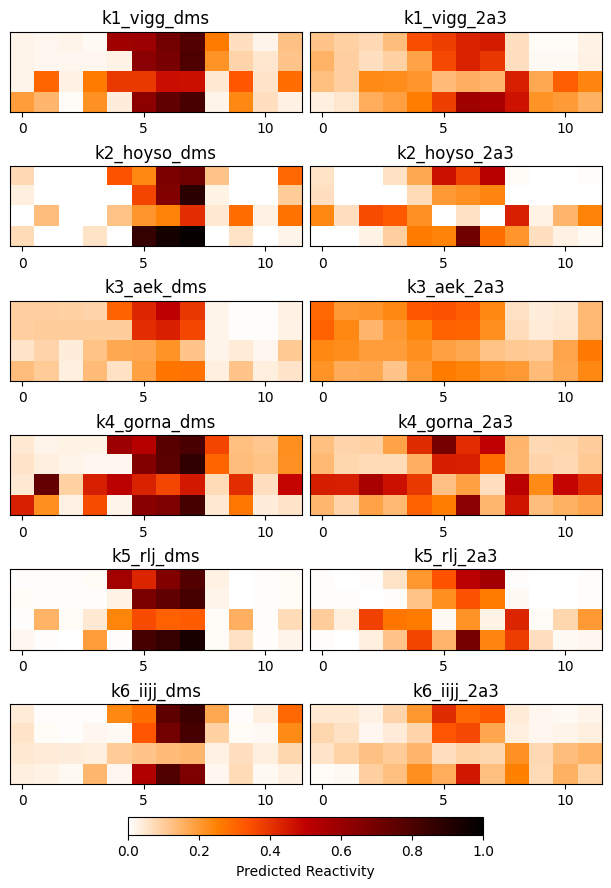

,id,sequence_id,index_in_sequence,k1_vigg_dms,k1_vigg_2a3,k2_hoyso_dms,k2_hoyso_2a3,k3_aek_dms,k3_aek_2a3,k4_gorna_dms,k4_gorna_2a3,k5_rlj_dms,k5_rlj_2a3,k6_iijj_dms,k6_iijj_2a3
0,0,s0,1,0.019989,0.116089,0.074674,0.057677,0.094727,0.296143,0.043818,0.127218,0.006454,0.006626,0.040619,0.043274
1,1,s0,2,0.017715,0.089966,0.000000,0.000000,0.095703,0.199219,0.022246,0.082532,0.004047,0.003609,0.006401,0.044617
2,2,s0,3,0.019608,0.075623,0.000000,0.000000,0.092651,0.207764,0.026250,0.090062,0.004112,0.004173,0.003983,0.030518
3,3,s0,4,0.014687,0.131714,0.000000,0.060081,0.085022,0.232178,0.023986,0.180007,0.009338,0.058594,0.004505,0.082153
4,4,s0,5,0.582031,0.349121,0.339783,0.169940,0.306885,0.331543,0.592762,0.414711,0.570312,0.203491,0.230835,0.206787
5,5,s0,6,0.586914,0.376953,0.231034,0.466415,0.424561,0.342285,0.522820,0.691446,0.428955,0.339111,0.284668,0.417236
6,6,s0,7,0.695801,0.430420,0.674408,0.371635,0.505371,0.316650,0.768986,0.410737,0.659180,0.514160,0.755859,0.294189
7,7,s0,8,0.784668,0.445312,0.707815,0.518405,0.390869,0.231689,0.808871,0.498038,0.781738,0.577148,0.838379,0.324463
8,8,s0,9,0.261475,0.066284,0.113338,0.010767,0.020874,0.059692,0.366767,0.146866,0.030838,0.007294,0.170898,0.039337
9,9,s0,10,0.063843,0.009224,0.000000,0.000000,0.006802,0.038452,0.125256,0.075630,0.003725,0.003428,0.006947,0.016068


In [1]:
%matplotlib inline

import sys
sys.path.insert(0, '..')

import os
import pandas as pd

from src.util.progress import NotebookProgress
from src.util.feature_cache import MemoryFeatureCache
from src.util.feature_gen import precompute_features
from src.util.plot import plot_reactivity
from src.util.load_models import load_models

# Sequences to infer reactivities for
SEQUENCES = ['GGGGAAAACCCC', 'GGGGGAAACCCC', 'UAUAAAAAUAUA', 'CCUAGAAAUAGG']
# Which models to run inference with
MODELS = ['k1_vigg', 'k2_hoyso', 'k3_aek', 'k4_gorna', 'k5_rlj', 'k6_iijj']
# Whenever an input feature (eg, MFE or BPPs from conventional models) is computed,
# cache it in memory so it can be reused in other (sub)models. If you want to preserve this
# cache between runs, you can use an FSFeatureCache instead, which will store the
# data in an hdf5 file using a specified gzip compression level
cache = MemoryFeatureCache()
# Number of parallel processes to use for precomputing features
n_jobs = os.cpu_count()
# Number of sequences to run in a single pytorch batch for most models
batch_size_small_model = 128
# Number of sequences to run in a single pytorch batch for k3_aek's "twintower" submodel,
# which requires substantialy more VRAM
batch_size_twintower = 8

# Display progress using notebook-style tqdm progress bars
with NotebookProgress(), cache:
    # Only import models that we actually use, since their transative imports incur overhead
    models = load_models(MODELS)

    # Precompute all needed features ahead of time so that it can be done in parallel
    # (and we can separately monitor its progress)
    precompute_features(MODELS, SEQUENCES, n_jobs)

    inferences = {
        model_name: model.infer(
            SEQUENCES,
            batch_size_small_model,
            *(
                (batch_size_twintower,) if model_name == 'k3_aek' else ()
            )
        ) for (model_name, model) in models.items()
    }

    # Plot heatmaps
    display(plot_reactivity(inferences))

    # Show raw data
    df = pd.DataFrame()
    first_inference = next(iter(inferences.values()))
    df['id'] = first_inference['id']
    df['sequence_id'] = first_inference['sequence_id']
    df['index_in_sequence'] = first_inference['index_in_sequence']
    for model_name, inference in inferences.items():
        df[f'{model_name}_dms'] = inference['reactivity_DMS_MaP']
        df[f'{model_name}_2a3'] = inference['reactivity_2A3_MaP']
    display(df)
